### Predict Future Sales
This notebook is based on the data provided in the Kaggle competition "Google Analytics Customer Revenue Prediction".
https://www.kaggle.com/c/ga-customer-revenue-prediction
In this notebook, I trained the model in two steps. In the first step, I used LightGBM classified to predict probabilities of making a purchase for each row. In the second step, I "filtered out" the rows with very low probability of purchase and trained the LightGBM regression model on the remaining data. Since majority of purchases in GStore are made by the small group of customers, such two-step process will allow us to filter out the non-purchasing customers and let us focus on the purchasing customers during the regression model training.

This notebook goes through the following steps to make a final prediction of a future revenue for each customer based on the provided data.
* Load data from csv files
* Convert json format features into individual columns
* Exclude unnecessary features
* Visualize data
* Create new features
* Prepare data for model training
* Perform classification using LGBMClassifier combined with grid search
* Filter out the low probability rows
* Perform regression using LGBMRegression combined with grid search
* Make prediction for the test data
* Save test data prediction into csv file
* Discussion: Future steps to improve this model

### Import some crucial libraries

In [1]:
import pandas as pd
pd.set_option('display.max_columns', 500)
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import datetime
import lightgbm as lgb
from sklearn import preprocessing
from sklearn.model_selection import GridSearchCV
import json
import os
from pandas.io.json import json_normalize
import datetime

### Loading the test and training data.
Some of the features are present in json format. We need to expand them in order to use in calculation. The following function does exactly that.

In [2]:
def load_df(csv_path='train.csv', nrows=None):
    JSON_COLUMNS = ['device', 'geoNetwork', 'totals', 'trafficSource']
    
    df = pd.read_csv(csv_path, 
                     converters={column: json.loads for column in JSON_COLUMNS}, 
                     dtype={'fullVisitorId': 'str'}, # Important!!
                     nrows=nrows)
    
    for column in JSON_COLUMNS:
        column_as_df = json_normalize(df[column])
        column_as_df.columns = [f"{column}.{subcolumn}" for subcolumn in column_as_df.columns]
        df = df.drop(column, axis=1).merge(column_as_df, right_index=True, left_index=True)
    print(f"Loaded {os.path.basename(csv_path)}. Shape: {df.shape}")
    return df

# expand the test and train data as pandas dataframes
# this step takes ~5 minutes on my laptop, so instead I created a separate file where I ran these steps once and 
# saved the outputs into csv files, so that I don't have to repeate this step every single time.
# uncomment the lines below when running for the first time

#%%time
#train_df = load_df()
#test_df = load_df("test.csv")

#train_df.to_csv('train_expanded.csv')
#test_df.to_csv('test_expanded.csv')

In [3]:
# load data with expanded json features from files created using the code above
train_df = pd.read_csv('train_expanded.csv', low_memory=False, dtype={'fullVisitorId': 'str'})
test_df = pd.read_csv('test_expanded.csv', low_memory=False, dtype={'fullVisitorId': 'str'})

### Check columns with a single unique value. If there is at least one value and a nan value, then we'll keep such features. Absence of a value (nan value) is itself informative.

In [4]:
constant_columns = [c for c in train_df.columns if train_df[c].nunique(dropna = False) == 1]
constant_columns

['socialEngagementType',
 'device.browserSize',
 'device.browserVersion',
 'device.flashVersion',
 'device.language',
 'device.mobileDeviceBranding',
 'device.mobileDeviceInfo',
 'device.mobileDeviceMarketingName',
 'device.mobileDeviceModel',
 'device.mobileInputSelector',
 'device.operatingSystemVersion',
 'device.screenColors',
 'device.screenResolution',
 'geoNetwork.cityId',
 'geoNetwork.latitude',
 'geoNetwork.longitude',
 'geoNetwork.networkLocation',
 'totals.visits',
 'trafficSource.adwordsClickInfo.criteriaParameters']

### Exclude some useless/extra features.

In [5]:
# features with constant values should be excluded, since they don't carry any useful information.
columns_to_exclude = constant_columns

# in addition, I will also exclude 'sessionId' feature, since it carries no useful information and 'Unnamed: 0',
# since it is an artifact I created when I expanded json features.
columns_to_exclude = columns_to_exclude + ['sessionId']

# I'll remove these features from both test and training data.
train_df = train_df.drop(columns_to_exclude, axis = 1)
test_df = test_df.drop(columns_to_exclude, axis = 1)

### At this point test and training data should have identical set of features, with a single exception of the training feature (y). let's see it is true.

In [6]:
set(train_df.columns) - set(test_df.columns)

{'totals.transactionRevenue', 'trafficSource.campaignCode'}

### As we can see, the training data has two additional features. 'totals.transactionRevenue' is the training feature, so it should stay, but the 'trafficSource.campaignCode' is unique for only the training data, so it has to be removed.

In [7]:
train_df = train_df.drop(['trafficSource.campaignCode'], axis = 1)
print('done')

done


### At this point,let's look at the features in more details.

In [8]:
train_df.head()

,channelGrouping,date,fullVisitorId,visitId,visitNumber,visitStartTime,device.browser,device.deviceCategory,device.isMobile,device.operatingSystem,geoNetwork.city,geoNetwork.continent,geoNetwork.country,geoNetwork.metro,geoNetwork.networkDomain,geoNetwork.region,geoNetwork.subContinent,totals.bounces,totals.hits,totals.newVisits,totals.pageviews,totals.transactionRevenue,trafficSource.adContent,trafficSource.adwordsClickInfo.adNetworkType,trafficSource.adwordsClickInfo.gclId,trafficSource.adwordsClickInfo.isVideoAd,trafficSource.adwordsClickInfo.page,trafficSource.adwordsClickInfo.slot,trafficSource.campaign,trafficSource.isTrueDirect,trafficSource.keyword,trafficSource.medium,trafficSource.referralPath,trafficSource.source
0,Organic Search,20160902,1131660440785968503,1472830385,1,1472830385,Chrome,desktop,False,Windows,Izmir,Asia,Turkey,(not set),ttnet.com.tr,Izmir,Western Asia,1.0,1,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,(not set),NaN,(not provided),organic,NaN,google
1,Organic Search,20160902,377306020877927890,1472880147,1,1472880147,Firefox,desktop,False,Macintosh,not available in demo dataset,Oceania,Australia,not available in demo dataset,dodo.net.au,not available in demo dataset,Australasia,1.0,1,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,(not set),NaN,(not provided),organic,NaN,google
2,Organic Search,20160902,3895546263509774583,1472865386,1,1472865386,Chrome,desktop,False,Windows,Madrid,Europe,Spain,(not set),unknown.unknown,Community of Madrid,Southern Europe,1.0,1,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,(not set),NaN,(not provided),organic,NaN,google
3,Organic Search,20160902,4763447161404445595,1472881213,1,1472881213,UC Browser,desktop,False,Linux,not available in demo dataset,Asia,Indonesia,not available in demo dataset,unknown.unknown,not available in demo dataset,Southeast Asia,1.0,1,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,(not set),NaN,google + online,organic,NaN,google
4,Organic Search,20160902,27294437909732085,1472822600,2,1472822600,Chrome,mobile,True,Android,not available in demo dataset,Europe,United Kingdom,not available in demo dataset,unknown.unknown,not available in demo dataset,Northern Europe,1.0,1,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,(not set),True,(not provided),organic,NaN,google


### Categorical features.
Let's look at some categorical features in more details. 

At first, let's go through the categorical features one by one and use the groupby function to see the total revenues, mean revenues and counts of non-zero transaction.

In [9]:
# Define a function to group by a certain feature, aggregate total revenue sum, mean and count and show the head of
# resulting dataframe (sorted)
def describe_function(col, df = train_df):
    display(df.groupby(col)['totals.transactionRevenue'].agg(['sum', 'mean','count']).sort_values(by="count", ascending=False).head())
    
features = ["channelGrouping", "device.browser", 
            "device.deviceCategory", "device.operatingSystem", 
            "geoNetwork.city", "geoNetwork.continent", 
            "geoNetwork.country", "geoNetwork.metro",
            "geoNetwork.networkDomain", "geoNetwork.region", 
            "geoNetwork.subContinent", "trafficSource.adContent"]

for col in features:
    describe_function(col, df = train_df)

,sum,mean,count
channelGrouping,,,
Referral,6.514299e+11,1.226567e+08,5311
Organic Search,3.263805e+11,9.493325e+07,3438
Direct,4.348406e+11,2.129484e+08,2042
Paid Search,4.355890e+10,9.307457e+07,468
Display,7.833746e+10,5.516723e+08,142


,sum,mean,count
device.browser,,,
Chrome,1.383105e+12,1.335946e+08,10353
Safari,5.239748e+10,6.717626e+07,780
Firefox,8.931632e+10,4.676247e+08,191
Internet Explorer,8.255550e+09,7.573899e+07,109
Edge,6.482970e+09,1.117753e+08,58


,sum,mean,count
device.deviceCategory,,,
desktop,1.480864e+12,1.411019e+08,10495
mobile,4.978581e+10,5.843405e+07,852
tablet,9.421340e+09,5.607940e+07,168


,sum,mean,count
device.operatingSystem,,,
Macintosh,8.563758e+11,1.332673e+08,6426
Windows,3.973127e+11,1.720713e+08,2309
Chrome OS,1.839378e+11,1.850480e+08,994
Linux,4.391040e+10,5.615141e+07,782
iOS,2.216690e+10,4.135616e+07,536


,sum,mean,count
geoNetwork.city,,,
not available in demo dataset,6.461611e+11,1.411140e+08,4579
New York,2.201435e+11,1.461776e+08,1506
Mountain View,1.261037e+11,1.043041e+08,1209
San Francisco,1.008740e+11,1.383731e+08,729
Sunnyvale,3.939358e+10,8.657930e+07,455


,sum,mean,count
geoNetwork.continent,,,
Americas,1.504672e+12,1.333574e+08,11283
Asia,1.740184e+10,1.392147e+08,125
Europe,6.747030e+09,8.540544e+07,79
Oceania,1.793230e+09,1.280879e+08,14
Africa,8.687760e+09,1.085970e+09,8


,sum,mean,count
geoNetwork.country,,,
United States,1.452441e+12,1.326067e+08,10953
Canada,3.282454e+10,1.727607e+08,190
Venezuela,1.337490e+10,2.123000e+08,63
Mexico,1.592790e+09,7.963950e+07,20
Taiwan,1.920890e+09,1.010995e+08,19


,sum,mean,count
geoNetwork.metro,,,
not available in demo dataset,6.461611e+11,1.411140e+08,4579
San Francisco-Oakland-San Jose CA,3.200364e+11,1.096391e+08,2919
New York NY,2.213181e+11,1.457958e+08,1518
Chicago IL,7.291288e+10,1.723709e+08,423
Los Angeles CA,5.133227e+10,1.496568e+08,343


,sum,mean,count
geoNetwork.networkDomain,,,
(not set),8.482641e+11,1.276545e+08,6645
comcast.net,1.231696e+11,1.318732e+08,934
verizon.net,5.291897e+10,1.128336e+08,469
unknown.unknown,3.490154e+10,8.725385e+07,400
rr.com,3.013218e+10,8.278071e+07,364


,sum,mean,count
geoNetwork.region,,,
not available in demo dataset,6.461611e+11,1.411140e+08,4579
California,3.754982e+11,1.136152e+08,3305
New York,2.201605e+11,1.460919e+08,1507
Illinois,7.291288e+10,1.723709e+08,423
Washington,3.517995e+10,1.047022e+08,336


,sum,mean,count
geoNetwork.subContinent,,,
Northern America,1.485265e+12,1.332913e+08,11143
South America,1.593731e+10,1.626256e+08,98
Eastern Asia,1.107522e+10,1.877156e+08,59
Southeast Asia,3.755990e+09,1.173747e+08,32
Western Europe,2.842340e+09,9.474467e+07,30


,sum,mean,count
trafficSource.adContent,,,
Google Merchandise Collection,1.495831e+10,1.278488e+08,117
Full auto ad IMAGE ONLY,2.623800e+08,5.247600e+07,5
Google Online Store,1.634200e+08,4.085500e+07,4
{KeyWord:Google Branded Gear},2.242400e+08,7.474667e+07,3
Swag with Google Logos,3.446000e+07,1.148667e+07,3


As we can see, using tables to visualize our data is very tricky, so next, I will draw the graphs instead.
For each of the following features, I calculated the sum and count of transactionRevenue and sorted in descending order (based on count) before plotting.

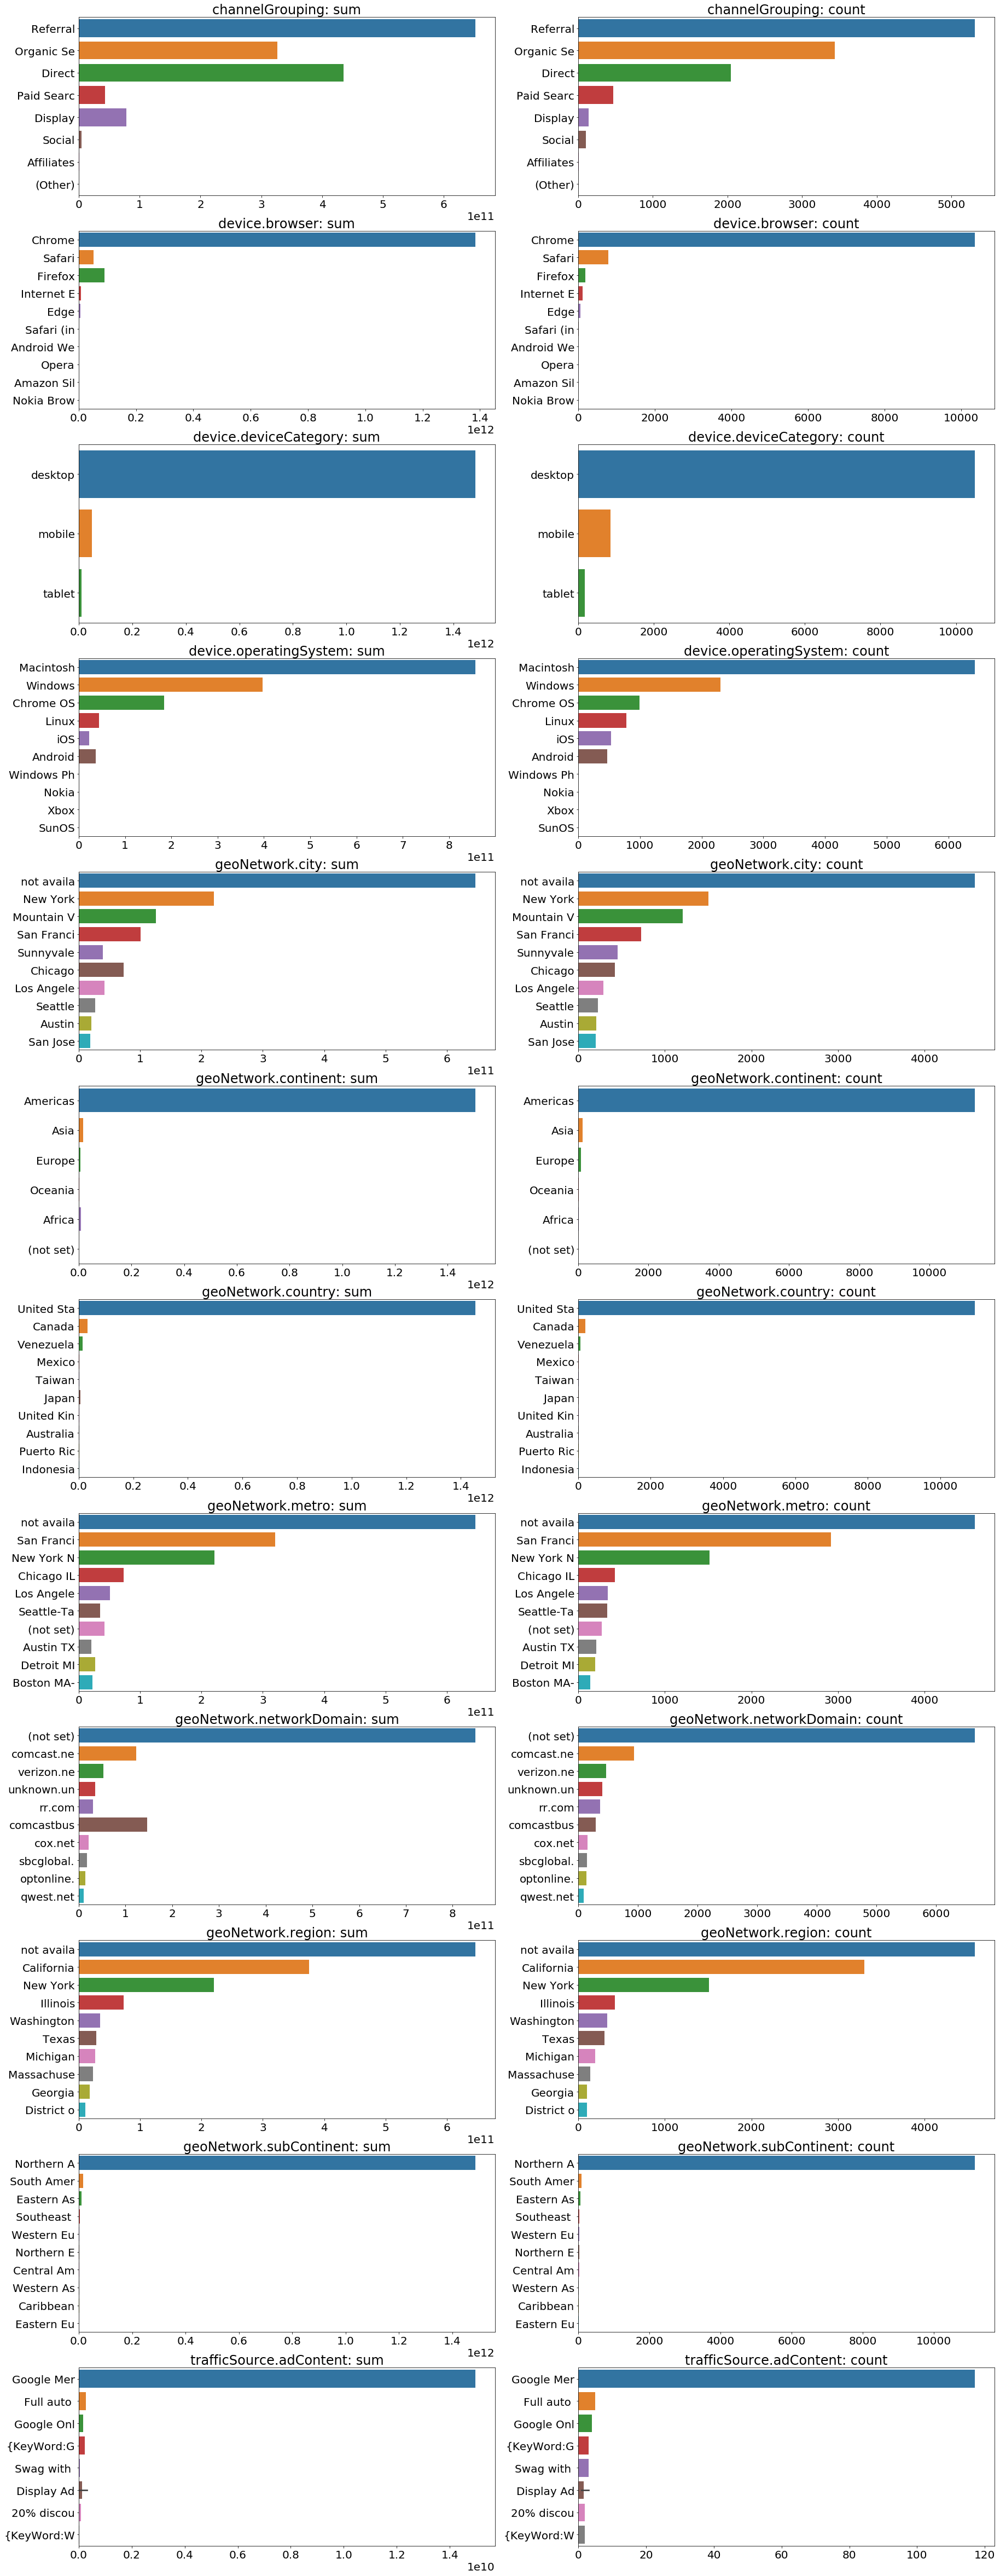

In [30]:
#temp_df = train_df.groupby('geoNetwork.continent')['totals.transactionRevenue'].agg(['sum', 'count']).sort_values(by="count", ascending=False).head(10)
plt.rcParams.update({'font.size': 20})
fig, axes = plt.subplots(len(features), 2, figsize=(30,85))
# sns.barplot(y=temp_df.index, x=temp_df['sum'], ax = axes[0,0])
# sns.barplot(y=temp_df.index, x=temp_df['count'], ax = axes[0,1])

for n in range(len(features)):
    col = features[n]
    temp_df = train_df.groupby(col)['totals.transactionRevenue'].agg(['sum', 'count']).sort_values(by="count", ascending=False).head(10)
    # Some names were too long, so I shortened them to just 10 characters
    y_temp = list(map(lambda x: x[:10], list(temp_df.index)))
    sns.barplot(y=y_temp, x=temp_df['sum'], ax = axes[n,0])
    sns.barplot(y=y_temp, x=temp_df['count'], ax = axes[n,1])
    axes[n,0].set_title(col + ': sum')
    axes[n,1].set_title(col + ': count')
    axes[n,0].set_xlabel('')
    axes[n,1].set_xlabel('')
    #axes[n,0].tick_params(labelsize=20)
    #axes[n,1].tick_params(labelsize=20)

As you can see, while there is some strong imbalance for some features (e.g. continent, country, etc.), there is a quite good variation in some other features (e.g. region, metro, city, etc.). Such variation is very useful when training models.

### "visitStartTime" column contains the same information as "date", so it can be replaced. I'll also generate features for the day of the week, hour, month and day of the month. I will also generate features for the difference between next and previous visit sessions for both test and train datasets.

In [31]:
train_df['date'] = pd.to_datetime(train_df['visitStartTime'], unit='s')
train_df['day_of_week'] = train_df['date'].dt.dayofweek
train_df['hour'] = train_df['date'].dt.hour
train_df['day_of_month'] = train_df['date'].dt.day
train_df['month'] = train_df['date'].dt.month

test_df['date'] = pd.to_datetime(test_df['visitStartTime'], unit='s')
test_df['day_of_week'] = test_df['date'].dt.dayofweek
test_df['hour'] = test_df['date'].dt.hour
test_df['day_of_month'] = test_df['date'].dt.day
test_df['month'] = test_df['date'].dt.month

train_df['next_session_1'] = (
        train_df['date'] - train_df[['fullVisitorId', 'date']].groupby('fullVisitorId')['date'].shift(1)
    ).astype(np.int64) // 1e9 // 60 // 60

train_df['next_session_2'] = (
        train_df['date'] - train_df[['fullVisitorId', 'date']].groupby('fullVisitorId')['date'].shift(-1)
    ).astype(np.int64) // 1e9 // 60 // 60

test_df['next_session_1'] = (
        test_df['date'] - test_df[['fullVisitorId', 'date']].groupby('fullVisitorId')['date'].shift(1)
    ).astype(np.int64) // 1e9 // 60 // 60

test_df['next_session_2'] = (
        test_df['date'] - test_df[['fullVisitorId', 'date']].groupby('fullVisitorId')['date'].shift(-1)
    ).astype(np.int64) // 1e9 // 60 // 60

# delete the "date" feature
train_df.drop('date', axis = 1, inplace = True)
test_df.drop('date', axis = 1, inplace = True)

print('done')

done


### Impute 0 for missing target values. No need to do this for other features since LightGBM can deal with them on its own.


In [32]:
train_df["totals.transactionRevenue"].fillna(0, inplace=True)
# test_id will be used in the end when generating the submission file.
test_id = test_df["fullVisitorId"].values

### label encode the categorical variables and convert the numerical variables to float


In [33]:
# define the categorical features
cat_cols = ["channelGrouping", "device.browser", 
            "device.deviceCategory", "device.operatingSystem", 
            "geoNetwork.city", "geoNetwork.continent", 
            "geoNetwork.country", "geoNetwork.metro",
            "geoNetwork.networkDomain", "geoNetwork.region", 
            "geoNetwork.subContinent", "trafficSource.adContent", 
            "trafficSource.adwordsClickInfo.adNetworkType", 
            "trafficSource.adwordsClickInfo.gclId", 
            "trafficSource.adwordsClickInfo.page", 
            "trafficSource.adwordsClickInfo.slot", "trafficSource.campaign",
            "trafficSource.keyword", "trafficSource.medium", 
            "trafficSource.referralPath", "trafficSource.source",
            'trafficSource.adwordsClickInfo.isVideoAd', 'trafficSource.isTrueDirect',
            'day_of_week', 'hour', 'day_of_month', 'month']

# label encode the categorical features
for col in cat_cols:
    print(col)
    lbl = preprocessing.LabelEncoder()
    lbl.fit(list(train_df[col].values.astype('str')) + list(test_df[col].values.astype('str')))
    train_df[col] = lbl.transform(list(train_df[col].values.astype('str')))
    test_df[col] = lbl.transform(list(test_df[col].values.astype('str')))

# define categorical values as 'categorical'. Might be a bit redundant, but I want to make sure that they are defined as such.
for c in cat_cols:
    train_df[c] = train_df[c].astype('category')
    test_df[c] = test_df[c].astype('category')
        

# make sure that the numerical columns are float type
num_cols = ["totals.hits", "totals.pageviews", "visitNumber", "visitStartTime", 'totals.bounces',  'totals.newVisits', 'next_session_1', 'next_session_2']    
for col in num_cols:
    train_df[col] = train_df[col].astype(float)
    test_df[col] = test_df[col].astype(float)

print('done')

channelGrouping
device.browser
device.deviceCategory
device.operatingSystem
geoNetwork.city
geoNetwork.continent
geoNetwork.country
geoNetwork.metro
geoNetwork.networkDomain
geoNetwork.region
geoNetwork.subContinent
trafficSource.adContent
trafficSource.adwordsClickInfo.adNetworkType
trafficSource.adwordsClickInfo.gclId
trafficSource.adwordsClickInfo.page
trafficSource.adwordsClickInfo.slot
trafficSource.campaign
trafficSource.keyword
trafficSource.medium
trafficSource.referralPath
trafficSource.source
trafficSource.adwordsClickInfo.isVideoAd
trafficSource.isTrueDirect
day_of_week
hour
day_of_month
month
done


### I am going to first perform a classification task where I will classify the rows based on the probability of a purchase, regardless of an exact value of the purchase.
Majority of visits don't result in a purchase and performing such classification first might help us remove the instances of visits with very low probability of visit. For this purpose, I will identify the visitors based on their 'fullVisitorId' and see if they have ever made even a single purchase. Then I will add a new identifier 'purchasing_customer' to each row. 0 if this customer has never made a purchase and 1 if they have. Then I will use this feature for the classification task. Next, I will have to use the results of the classification to predict the feature for the test set (since we don't know who makes a purchase in the test set).

In [34]:
# calculate the total revenue per visitor. I'll use this later to see if a visitor has ever made a purchase
total_purchase_df = train_df[['fullVisitorId','totals.transactionRevenue']].groupby('fullVisitorId').sum()
total_purchase_df = total_purchase_df['totals.transactionRevenue'].to_dict()

In [35]:
# create a feature purchasing_customer.
# 1 indicates that the visitor has made a purchase at least once. 0 indicates no purchase ever.
train_df['purchasing_customer'] = train_df["fullVisitorId"].apply(lambda x: 1 if total_purchase_df[x] > 0 else 0)
print("there are ", train_df['purchasing_customer'].sum(), "entres for customers who made a purchase at some point")

there are  36110 entres for customers who made a purchase at some point


### Define the parameters for the grid search for classification task. 
Parameters for grid search and the fixed parameters need to be in separate dictionaries. For the parameters for which I already performed the grid search, I will put the tested options next to them as comments so that I don't need to test them again.

In [36]:
# Set fixed params
params_classification = {#"objective" : "regression",
        "metric" : "rmse",
        'max_depth' : -1,
        'max_bin': 512,
        "min_child_samples" : 100,
        "bagging_fraction" : 0.7,
        "feature_fraction" : 0.5,
        "bagging_frequency" : 5,
        "bagging_seed" : 2018,
        "verbosity" : -1}

# Create parameters to search
gridParams_classification = {
    'learning_rate': [0.1], #0.1, 0.05, 0.2
    'n_estimators': [100], # 70, 50
    'num_leaves': [70], # 30, 50
    'colsample_bytree': [0.3], # 0.1, 1
    'subsample': [0.3], # 0.1, 1
    'reg_alpha': [1.4], # 1, 1.2
    'reg_lambda': [1], # 1.2, 1.4
    }

### create training dataframes. Of course, the 'totals.transactionRevenue' will be excluded, since it is not present in the test set.

In [37]:
X_train_df = train_df[cat_cols + num_cols]
y_train_df = train_df['purchasing_customer']

# X_test_df will be used to predict the 'purchasing_customer' feature for the test set.
X_test_df = test_df[cat_cols + num_cols]

### Create the classifier and perform classification task.

In [38]:
# Create classifier to use. Note that parameters have to be input manually, not as a dict!

mdl_classifier = lgb.LGBMClassifier(
          objective = 'binary',
          n_jobs = 3,
          silent = True,
          max_depth = params_classification['max_depth'],
          max_bin = params_classification['max_bin'],
          feature_fraction = params_classification['feature_fraction'],
          min_child_samples = params_classification['min_child_samples'],
          bagging_fraction = params_classification['bagging_fraction']
          )

In [39]:
# Create the grid search with 4 fold cross validation
grid_classification = GridSearchCV(mdl_classifier, gridParams_classification,
                    verbose=0,
                    cv=5,
                    n_jobs=2)

In [40]:
# Run the grid
grid_classification.fit(X_train_df, y_train_df)

# Print the best parameters found
print(grid_classification.best_params_)
print(grid_classification.best_score_)

{'colsample_bytree': 0.3, 'learning_rate': 0.1, 'n_estimators': 100, 'num_leaves': 70, 'reg_alpha': 1.4, 'reg_lambda': 1, 'subsample': 0.3}
0.9679390208409644


In [41]:
# check the quality of calculation
from sklearn.metrics import mean_squared_error
from math import sqrt

rms = sqrt(mean_squared_error(y_train_df, grid_classification.predict_proba(X_train_df)[:,1]))
print('rms = ', rms)

from sklearn.metrics import accuracy_score
accur = accuracy_score(y_train_df, grid_classification.predict(X_train_df))
print('accuracy = ', accur)


rms =  0.1441569026426291
accuracy =  0.9715466002990086


C:\Users\Leo\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


### Predict probability of 1 (of making a purchase). probability of 0 would be (1 - proba[1])

In [42]:
train_df['proba_prediction_train'] = grid_classification.predict_proba(X_train_df)[:,1]
test_df['proba_prediction_train'] = grid_classification.predict_proba(X_test_df)[:,1]

### Now I will perform the regression task to predict the revenue first for each visit, and then sum up these predictions to predict the revenue per customer.
I will use the results of the classification task in two ways. First, I will use the new feature of 'proba_prediction_train' which predicts the probability of purchase for each row. Second, I will used this feature additionally to filter out the rows with very low probability of purchase. I do not know if such action will be useful, or what is the optimal cut off level for such filter, thus I will test several cut off levels and see if such treatment improves the score.

Similar to the classification task, I will employ the grid search for the regression task as well.

In [43]:
# Set params
params_regression = {"objective" : "regression",
        "metric" : "rmse",
        'max_depth' : -1,
        'max_bin': 512,
        "min_child_samples" : 100,
        "bagging_fraction" : 0.7,
        "feature_fraction" : 0.5,
        "bagging_frequency" : 5,
        "bagging_seed" : 2018,
        "verbosity" : -1}

# Create parameters to search
gridParams_regression = {
    'learning_rate': [0.10], # 0.15, 0.10
    'n_estimators': [70],
    'num_leaves': [50],
    'colsample_bytree': [0.3],
    'subsample': [0.3],
    'reg_alpha': [1], #[1,1.2, 1.4],
    'reg_lambda': [1], #[1,1.2,1.4]
    }

In [44]:
# Create classifier to use. Note that parameters have to be input manually
# not as a dict!

mdl_regression = lgb.LGBMRegressor(
          objective = 'regression',
          n_jobs = 3, # Updated from 'nthread'
          silent = True,
          max_depth = params_regression['max_depth'],
          max_bin = params_regression['max_bin'],
          feature_fraction = params_regression['feature_fraction'],
          min_child_samples = params_regression['min_child_samples'],
          bagging_fraction = params_regression['bagging_fraction']
          )

In [45]:
# cuot off levels for the probability of making a purchase
# 0.0 will indicate that no data will be cut off
probability_cutoff_list = [0.0, 0.01, 0.05, 0.1, 0.25]

grid_regression = []
for probability_cutoff in probability_cutoff_list:
    X_train_df = train_df[train_df['proba_prediction_train']>probability_cutoff][cat_cols + num_cols + ['proba_prediction_train']]
    y_train_df = np.log1p(train_df[train_df['proba_prediction_train']>probability_cutoff]["totals.transactionRevenue"].values)

    X_test_df = test_df[test_df['proba_prediction_train']>probability_cutoff][cat_cols + num_cols + ['proba_prediction_train']]
    
    # Create the grid search with 4 fold cross validation
    grid = GridSearchCV(mdl_regression, gridParams_regression,
                        verbose=0,
                        cv=5,
                        n_jobs=2)
    # Run the grid
    grid.fit(X_train_df, y_train_df)
    
    # add results of grid search to the list of grid_regression
    grid_regression = grid_regression + [grid]

    # Print the best parameters found
    print(grid.best_params_)
    print(grid.best_score_)

{'colsample_bytree': 0.3, 'learning_rate': 0.1, 'n_estimators': 70, 'num_leaves': 50, 'reg_alpha': 1, 'reg_lambda': 1, 'subsample': 0.3}
0.40150545288399664
{'colsample_bytree': 0.3, 'learning_rate': 0.1, 'n_estimators': 70, 'num_leaves': 50, 'reg_alpha': 1, 'reg_lambda': 1, 'subsample': 0.3}
0.3750529892472512
{'colsample_bytree': 0.3, 'learning_rate': 0.1, 'n_estimators': 70, 'num_leaves': 50, 'reg_alpha': 1, 'reg_lambda': 1, 'subsample': 0.3}
0.36480176950934673
{'colsample_bytree': 0.3, 'learning_rate': 0.1, 'n_estimators': 70, 'num_leaves': 50, 'reg_alpha': 1, 'reg_lambda': 1, 'subsample': 0.3}
0.3584131382470788
{'colsample_bytree': 0.3, 'learning_rate': 0.1, 'n_estimators': 70, 'num_leaves': 50, 'reg_alpha': 1, 'reg_lambda': 1, 'subsample': 0.3}
0.35130691528842795


### The best score is achieved when no data it cut off. In other words, removing the rows with low predicted probability of making a purchase does not improve out predictions. Still, it was an interesting option to test.

In [46]:
# predict revenue for the test data used in the regression test. 
# Since the 0.0 cut off level gives the best results, the whole test set will be used.
X_test_df['prediction'] = grid_regression[0].predict(X_test_df)

In [47]:
# following lines are technically not necessary since I ended up using the 0.0 cut off level, but I'll still keep them.
test_df['prediction'] = 0
test_df.loc[X_test_df.index.values,'prediction'] = X_test_df[['prediction']]

# replace all the negative predictions with 0, as there can be no negative value
test_df['prediction'] = test_df['prediction'].apply(lambda x: x if x > 0 else 0)

### Create a submission file

In [48]:
# Load submission template file
submission = pd.read_csv('sample_submission.csv')
submission.head()

,fullVisitorId,PredictedLogRevenue
0,0000000259678714014,0.0
1,0000049363351866189,0.0
2,0000053049821714864,0.0
3,0000059488412965267,0.0
4,0000085840370633780,0.0


In [49]:
sub_df = pd.DataFrame({"fullVisitorId":test_id})
sub_df["PredictedLogRevenue"] = np.expm1(test_df['prediction'].values)
sub_df = sub_df.groupby("fullVisitorId")["PredictedLogRevenue"].sum().reset_index()
sub_df.columns = ["fullVisitorId", "PredictedLogRevenue"]
sub_df["PredictedLogRevenue"] = np.log1p(sub_df["PredictedLogRevenue"])

now = datetime.datetime.now()
now = now.strftime("%Y-%m-%d")
sub_df.to_csv("predict_revenues_" + now + ".csv", index=False)
print('Finished')

Finished


### Discussion
In this notebook, I successfully used the LGB classification and regression models to predict the future revenue for the users. There are number of additional methods we could use to improve prediction by our model.
1. Blending. Often model can be improved by blending the predictions by different approaches (SVM, linear regression, RNN, etc).
2. In current approach, I did not take into consideration the chronology of the purchases. The model might perform better if we treat the data as a time series.
3. During the classification step I predicted the probability of a revenue (yes or no without an actual value) for each row. Since in the final step of the process we are predicting the revenue for each user, not each row, we might get a better result if we predict the probabilities for users instead of the rows during the classification step.